In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools
import os
import random

# to plot some images
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
trainY = trainY.flatten()
testX = np.load('testX.npy')
testY = np.load('testY.npy')
testY = testY.flatten()

trainY = trainY.astype(int)
testY = testY.astype(int)

with open("testPaths.txt", "r") as f:
    testPaths = f.read().strip().split("\n")

with open("trainPaths.txt", "r") as f:
    trainPaths = f.read().strip().split("\n")
    

print(f"shape of trainX is : {trainX.shape}")
print(f"shape of trainY is : {trainY.shape}")
print(f"shape of testX is : {testX.shape}")
print(f"shape of testY is : {testY.shape}")
print(f"length of trainPaths is : {len(trainPaths)}")
print(f"length of testPaths is : {len(testPaths)}")

shape of trainX is : (18192, 4096)
shape of trainY is : (18192,)
shape of testX is : (4551, 4096)
shape of testY is : (4551,)
length of trainPaths is : 18192
length of testPaths is : 4551


In [3]:
trainX = np.hstack([trainX, np.ones((trainX.shape[0], 1))])
testX = np.hstack([testX, np.ones((testX.shape[0], 1))])

print(f"shape of trainX is : {trainX.shape}")
print(f"shape of testX is : {testX.shape}")

shape of trainX is : (18192, 4097)
shape of testX is : (4551, 4097)


In [4]:
class LinearSVM(object):
    
    def __init__(self, lr, epochs, delta=1, reg=1e-5):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.delta = 1 
        self.reg = reg
        
        self.numberOfSamples = None 
        self.numberOfFeatures = None 
        self.numberOfClasses = None 
        

    def fit(self, features, labels, test_features, test_labels):
        self.numberOfSamples = features.shape[0]
        self.numberOfFeatures = features.shape[1]
        self.numberOfClasses = len(np.unique(labels))
        
        self.weights = 0.01 * np.random.rand(self.numberOfFeatures, self.numberOfClasses)
                
        print("Starting to train.")
        print("-----------------")
        loss_history_training = []
        loss_history_test = []

        for i in range(self.epochs):
            
            loss, dW, outputs = self.loss(features, labels, self.reg)

            self.weights = self.weights - self.lr * dW
            
            loss_history_training.append(loss)
            
            test_loss, _ , _ = self.loss(test_features, test_labels, self.reg)
            loss_history_test.append(test_loss)

            if i == 0 or (i - 9) % 10 == 0:
                print(f"epoch: {i+1}/{self.epochs} , loss: {loss:.2f} training accuracy: {self.evaluate(labels, outputs):.2f}")
        
        return loss_history_training, loss_history_test
    
        
    def loss(self, features, labels, reg):
        loss = 0.0
        dW = np.zeros(self.weights.shape)
        
        scores = np.dot(features,self.weights)
        
        correctClassScores = scores[ np.arange(len(features)), labels].reshape(len(features),1)
        
        margin = np.maximum(0, scores - correctClassScores + self.delta)
        
        margin[np.arange(len(features)), labels] = 0
        
        loss = margin.sum() / len(features)

        # l2 regularization
        loss += self.reg * np.sum(self.weights * self.weights)
        
        # now, calculate the gradients.        
        margin[margin > 0] = 1
        
        validMarginCount = margin.sum(axis=1)
        
        margin[np.arange(len(features)),labels ] -= validMarginCount
        
        dW = np.dot(features.T, margin) / len(features)

        # regularization gradient
        dW = dW + self.reg * 2 * self.weights
        
        return loss, dW, np.argmax(scores, axis=1)
        
    # predict 1 sample
    def predict(self, features):
        scores = np.dot(features, self.weights)
        label = np.argmax(scores)
        return label

    def evaluate(self, targets, outputs):
        return np.mean(targets == outputs)

In [5]:
learning_rate = 0.001
epochs = 30

model = LinearSVM(learning_rate, epochs, delta=1, reg=5*1e-5)
before = time()
history_train, history_test = model.fit(trainX, trainY, testX, testY)
    
print("-----------------")
print(f"time elapsed: {time()-before:.2f} seconds ")

Starting to train.
-----------------
epoch: 1/30 , loss: 8.69 training accuracy: 0.16
epoch: 10/30 , loss: 0.41 training accuracy: 0.90
epoch: 20/30 , loss: 0.30 training accuracy: 0.93
epoch: 30/30 , loss: 0.28 training accuracy: 0.93
-----------------
time elapsed: 18.93 seconds 


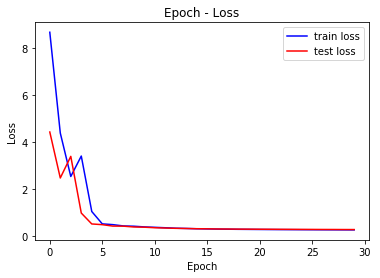

In [6]:
plt.plot(history_train, "-b", label="train loss")
plt.plot(history_test, "-r", label="test loss")
plt.title("Epoch - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [7]:
# test
classes = np.unique(trainY)
conf_matrix = np.zeros(shape=(len(classes),len(classes)))
for i, (features, label) in enumerate(zip(testX, testY)):
    rowMatrix = np.reshape(features, (1, len(features)))
    
    prediction = model.predict(rowMatrix)
    conf_matrix[label][prediction] += 1

In [8]:
acc = correct / len(testX)
recall = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1))
precision = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0))

print(f"overall accuracy is {acc:.2f}")
print(f"overall precision is {precision:.2f}")
print(f"overall recall is {recall:.2f}")

overall accuracy is 0.93
overall precision is 0.93
overall recall is 0.93


In [9]:
# from scikitlearn 0.18 - old version
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

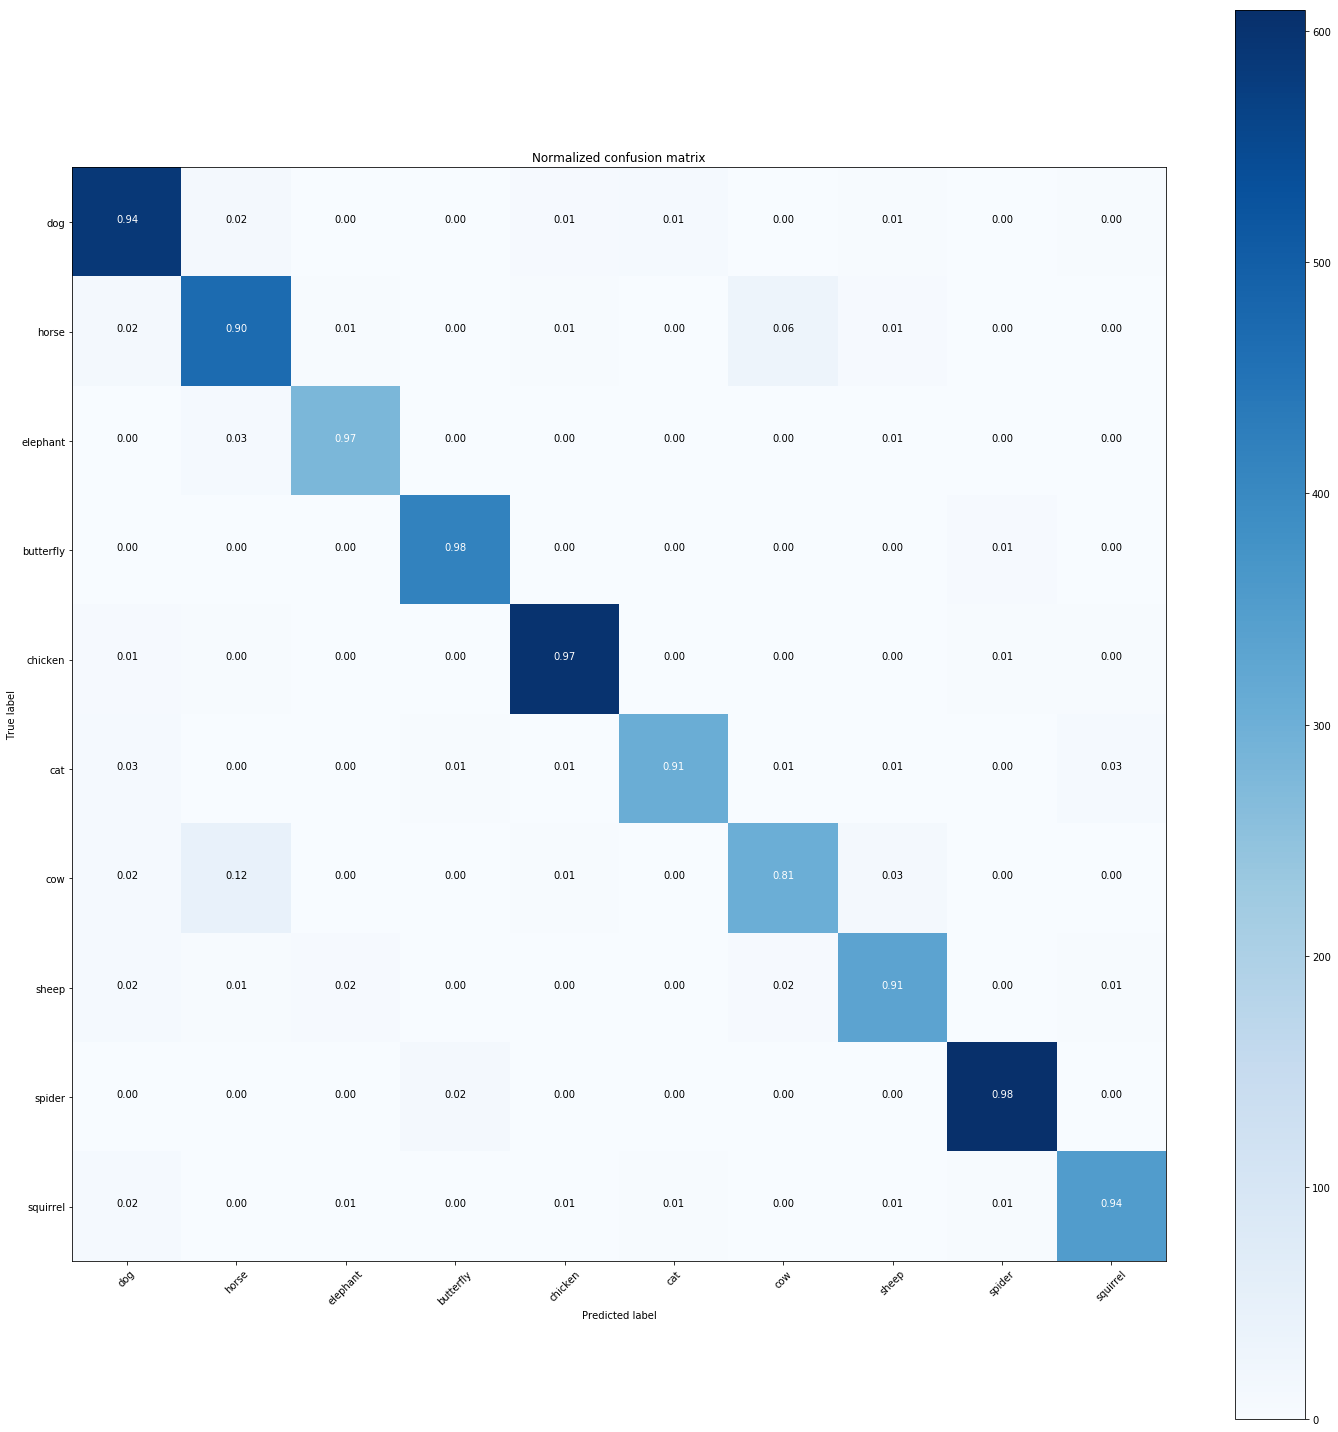

In [10]:
class_names = ["dog", "horse", "elephant", "butterfly", "chicken", "cat", "cow", "sheep", "spider","squirrel"]

plt.figure()
plt.figure(figsize=(20,20))

plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [11]:
# to free up memory
del trainX
del trainY

In [12]:
numberToClass = {
                 0: "dog",
                 1: "horse",
                 2: "elephant",
                 3: "butterfly",
                 4: "chicken",
                 5: "cat",
                 6: "cow",
                 7: "sheep",
                 8: "spider",
                 9: "squirrel"
}

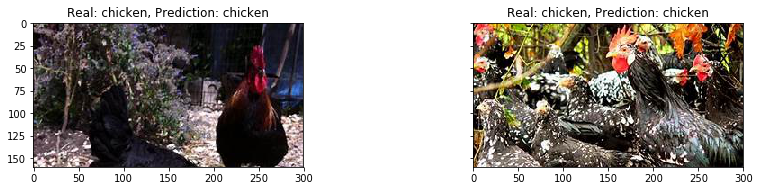

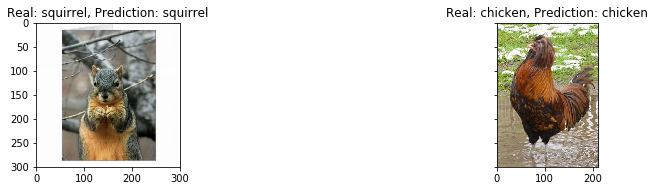

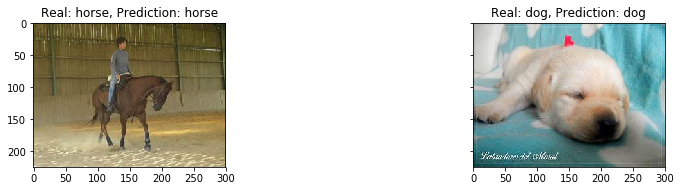

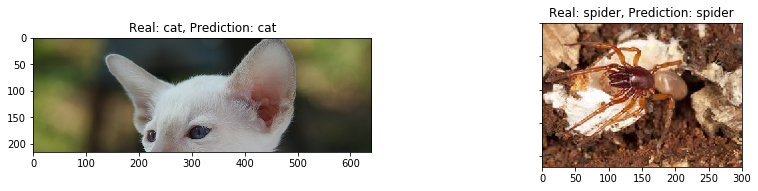

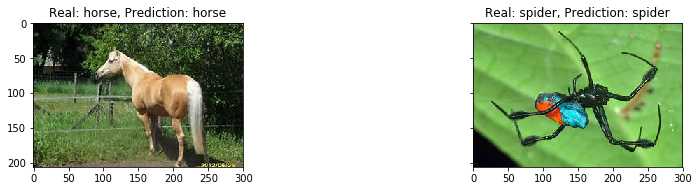

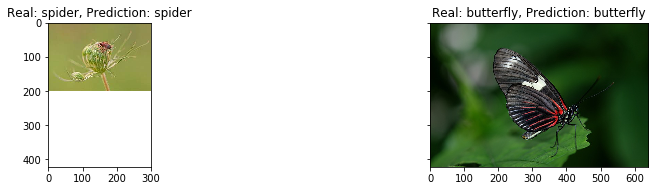

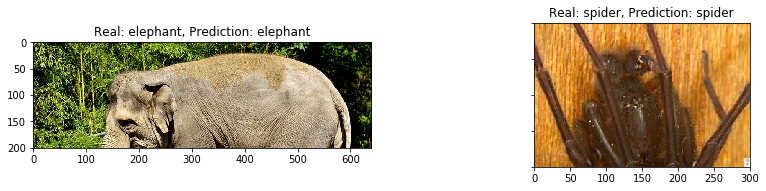

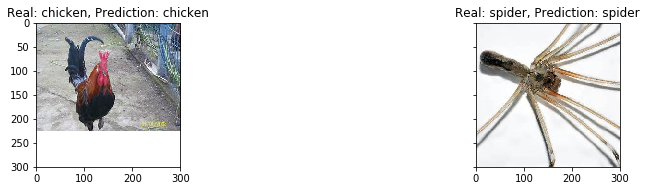

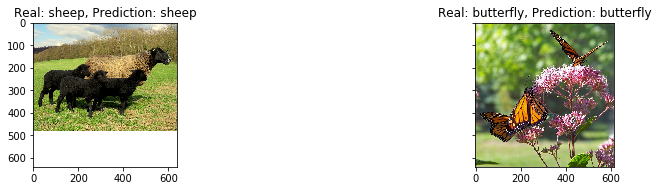

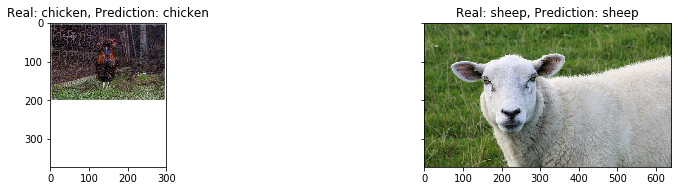

In [14]:
testNumber = 20
for i in range(int(testNumber/2)):
    randIndex1 = random.randint(0, len(testX) -1)
    randIndex2 = random.randint(0, len(testX) -1)

        
    im1 = Image.open(testPaths[randIndex1]).convert("RGB")
    im2 = Image.open(testPaths[randIndex2]).convert("RGB")

    
    features1 = testX[randIndex1]
                                        
    features2 = testX[randIndex2]
                                              
    label1 = testY[randIndex1]
    label2 = testY[randIndex2]


    
    prediction1 = model.predict(features1)
    prediction2 = model.predict(features2)

    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    plt.subplots_adjust(left=0.0, bottom=0, right=1.8, top=0.5,wspace=0.3, hspace=0.3)

    ax1.imshow(im1)
    ax2.imshow(im2)
    ax1.set_title(f"Real: {numberToClass[label1]}, Prediction: {numberToClass[prediction1]}")
    ax2.set_title(f"Real: {numberToClass[label2]}, Prediction: {numberToClass[prediction2]}")

    plt.show() 

In [ ]:
vggModel = models.vgg16(pretrained=True)
vggModel.classifier = nn.Sequential(*list(vggModel.classifier.children())[:-3])
input_size = 224
mean = [0.5177, 0.5003, 0.4126]
std = [0.2135, 0.2130, 0.2151]
tensor_transform = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.ToTensor()])

In [ ]:
os.chdir("D:\\python\\animal classifier")



root_dir = os.getcwd()
testDir = os.path.join(root_dir, "plotImgs")
os.chdir(testDir)

file = open("labels.txt", "r")
labels = file.read().strip().split("-")

with torch.no_grad():
    for i in range(len(os.listdir())): # 1 file is txt file
        if f"{i+1}.jpg" in os.listdir():
            path = f"{i+1}.jpg"
                   
        elif f"{i+1}.jpeg" in os.listdir():
            path = f"{i+1}.jpeg"
                   
        else:
            continue

        imgPIL = Image.open(path) #PIL image
        imgTensor = tensor_transform(imgPIL) #torch.FloatTensor 3,224,224
        features = vggModel(imgTensor[None, ...])
        features = features.detach().numpy()  
        
        features = np.hstack([features, np.ones((features.shape[0], 1))])
        
        prediction = model.predict(features)
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        plt.subplots_adjust(left=0.0, bottom=0, right=1.3, top=0.5,wspace=0.3, hspace=0.3)
        
        ax1.imshow(imgPIL)
        ax2.imshow( imgTensor.permute(1, 2, 0) )
        ax1.set_title(f"Real: {numberToClass[prediction]}")
        ax2.set_title(f"Prediction: {numberToClass[prediction]}")

        plt.show() 